# Importing libraries


In [1]:
# !python3 -m pip install pattern
# !python3 -m pip install krippendorff
# !python3 -m pip install simpledorff

In [2]:
from google.colab import drive
import pandas as pd

from collections import Counter
import matplotlib.pyplot as plt

import simpledorff

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from pattern.nl import sentiment

from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import numpy as np
from scipy.sparse import vstack

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Importing dataset

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_master = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BSc AI Thesis/comments_new.csv')

In [5]:
df = df_master.head(10000)

# Data cleaning

## Dropping unused features

In [6]:
unused_features = ['user_id', 'created_at', 'status', 'reply_count', 'respect_count', 'is_featured']
df.drop(columns=unused_features, axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

## Dropping comments with just links

In [7]:
# Filtering rows starting with 'http' and not having any blank spaces
df_links = df[(df['text'].str[:4] == "http") & (~df['text'].str.contains(' '))]

# Drop the filtered rows
df.drop(df_links.index, inplace=True)
df.reset_index(drop=True, inplace=True)

# Creating gold label column

In [8]:
# Defining annotation labels
labels = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5', 'Label 6', 'Label 7', 'Label 8', 'Label 9', 'Label 10', 'Label 11', 'Label 12']

# Creating gold labels based on majority
df['Gold Label'] = df[labels].apply(lambda row: row.value_counts().idxmax() if row.count() > 0 else None, axis=1)

# Label distribution

In [9]:
count = Counter(df['Gold Label'])

subjective = count['subjective']
objective = count['objective']
total = subjective + objective

subjective_percent = round((subjective / total) * 100, 2)
objective_percent = round((objective / total) * 100, 2)

# Displaying the results
print(f"Subjective labels case 1: {subjective_percent}%")
print(f"Objective labels case 1: {objective_percent}%")

Subjective labels case 1: 57.58%
Objective labels case 1: 42.42%


## Plotting the distribution

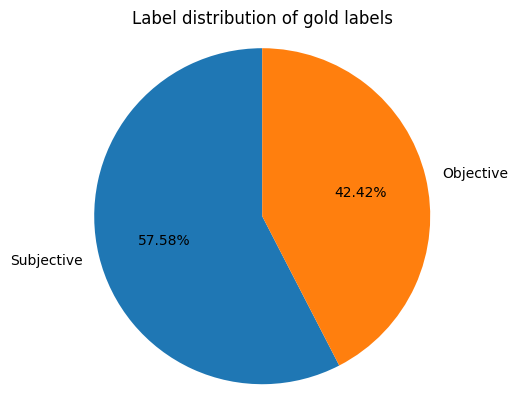

In [10]:
plot_labels = ['Subjective', 'Objective']
percentages = [subjective_percent, objective_percent]

plt.pie(percentages, labels=plot_labels, autopct='%0.2f%%', startangle=90)
plt.axis('equal')
plt.title('Label distribution of gold labels')
plt.show()

# Krippendorff's alpha

In [11]:
# Calculating Krippendorff's alpha
df_alpha = df.pivot_table(columns='comment_id', values=labels, aggfunc="first")
alpha = simpledorff.calculate_krippendorffs_alpha(df_alpha)

# Displaying the result
print(f"Krippendorff's alpha: {round(alpha, 2)}")

Krippendorff's alpha: 0.54


# Data pre-processing

In [12]:
tokeniser = WordPunctTokenizer()
stopwords = set(stopwords.words('dutch'))

preprocessed_text = []

for comment in df['text']:
  # Normalising the comments by converting to lowercase, removing numbers and removing stopwords
  tokens = tokeniser.tokenize(comment.lower())
  tokens = [token for token in tokens if token.isalpha()]
  tokens = [token for token in tokens if token not in stopwords]

  preprocessed_text.append(' '.join(tokens))

df['preprocessed text'] = preprocessed_text

# Objective vs. subjective: Clustering

## Case 1: Analysis on comment level

In [13]:
# Feature extraction
vectoriser = TfidfVectorizer()
comment_vectors = vectoriser.fit_transform(preprocessed_text)

# Initial clustering based on comment
kmeans = KMeans(n_clusters=2, n_init='auto')
kmeans.fit(comment_vectors)

cluster_labels_case_1_init = kmeans.labels_

# Calculating average subjectivity for each cluster
cluster_sentiments = {0: [], 1: []}

for comment, cluster_label in zip(df['preprocessed text'], cluster_labels_case_1_init):
  sentiment_value = sentiment(comment)[1]
  cluster_sentiments[cluster_label].append(sentiment_value)

avg_subjectivity = {label: sum(values) / len(values) for label, values in cluster_sentiments.items()}

# Re-assingning clusters based on subjectivity
subjective_cluster, objective_cluster = (0, 1) if avg_subjectivity[0] > avg_subjectivity[1] else (1, 0)
cluster_labels_case_1 = [1 if label == subjective_cluster else 0 for label in cluster_labels_case_1_init]

## Case 2: Analysis on sentence level

In [14]:
cluster_labels_case_2 = []

for comment in df['preprocessed text']:
  # Splitting the comment sentences into tokens
  sentences = nltk.sent_tokenize(comment)

  # Calculating subjectivity for sentences
  subjective_values = [sentiment(sentence)[1] for sentence in sentences]
  subjective_count = sum(1 for val in subjective_values if val > 0.5)
  objective_count = len(subjective_values) - subjective_count

  # Assigning clusters based on subjectivity
  cluster_labels_case_2.append(1 if subjective_count > objective_count else 0)

## Adding cluster labels to df

In [15]:
df.loc[:, "Label Clustering: Case 1"] = pd.Series(cluster_labels_case_1, index=df.index).map({1: 'subjective', 0: 'objective'})
df.loc[:, "Label Clustering: Case 2"] = pd.Series(cluster_labels_case_2, index=df.index).map({1: 'subjective', 0: 'objective'})

## Comparing the two cases

In [16]:
# Counting the same predictions between both cases
matches = (df['Label Clustering: Case 1'] == df['Label Clustering: Case 2']).sum()

# Calculating the percentage similarity
percentage_similarity = round((matches / len(df)) * 100, 2)

# Displaying the result
print(f"Percentage similarity between case 1 and case 2: {percentage_similarity}%")

Percentage similarity between case 1 and case 2: 46.24%


## Comparing case 1 to gold labels

In [17]:
print(f"Classification report for case 1 vs gold labels:\n {classification_report(df['Gold Label'].iloc[:99], df['Label Clustering: Case 1'].iloc[:99])}")

Classification report for case 1 vs gold labels:
               precision    recall  f1-score   support

   objective       0.44      0.95      0.61        42
  subjective       0.78      0.12      0.21        57

    accuracy                           0.47        99
   macro avg       0.61      0.54      0.41        99
weighted avg       0.64      0.47      0.38        99



## Comparing case 2 to gold labels

In [18]:
print(f"Classification report for case 2 vs gold labels:\n {classification_report(df['Gold Label'].iloc[:99], df['Label Clustering: Case 2'].iloc[:99])}")

Classification report for case 2 vs gold labels:
               precision    recall  f1-score   support

   objective       0.47      0.43      0.45        42
  subjective       0.61      0.65      0.63        57

    accuracy                           0.56        99
   macro avg       0.54      0.54      0.54        99
weighted avg       0.55      0.56      0.55        99



## Distribution of labels in case 1

In [19]:
count_case_1 = Counter(df['Label Clustering: Case 1'])

subjective_count_1 = count_case_1['subjective']
objective_count_1 = count_case_1['objective']
total_1 = subjective_count_1 + objective_count_1

subjective_percent_1 = round((subjective_count_1 / total_1) * 100, 2)
objective_percent_1 = round((objective_count_1 / total_1) * 100, 2)

# Displaying the results
print(f"Subjective labels case 1: {subjective_percent_1}%")
print(f"Objective labels case 1: {objective_percent_1}%")

Subjective labels case 1: 15.38%
Objective labels case 1: 84.62%


### Plotting distribution of case 1

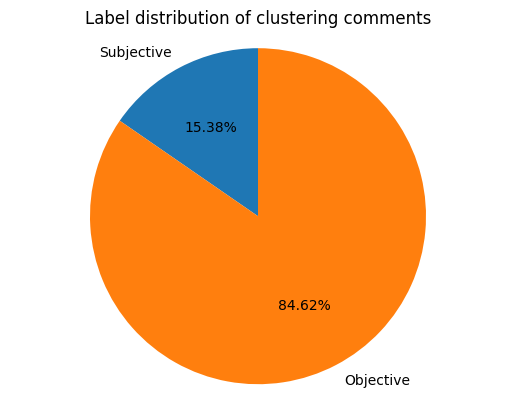

In [20]:
percentages = [subjective_percent_1, objective_percent_1]

plt.pie(percentages, labels=plot_labels, autopct='%0.2f%%', startangle=90)
plt.axis('equal')
plt.title('Label distribution of clustering comments')
plt.show()

## Distribution of labels in case 2

In [21]:
count_case_2 = Counter(df['Label Clustering: Case 2'])

subjective_count_2 = count_case_2['subjective']
objective_count_2 = count_case_2['objective']
total_2 = subjective_count_2 + objective_count_2

subjective_percent_2 = round((subjective_count_2 / total_2) * 100, 2)
objective_percent_2 = round((objective_count_2 / total_2) * 100, 2)

# Displaying the results
print(f"Subjective labels case 2: {subjective_percent_2}%")
print(f"Objective labels case 2: {objective_percent_2}%")

Subjective labels case 2: 58.02%
Objective labels case 2: 41.98%


### Plotting distribution of case 2

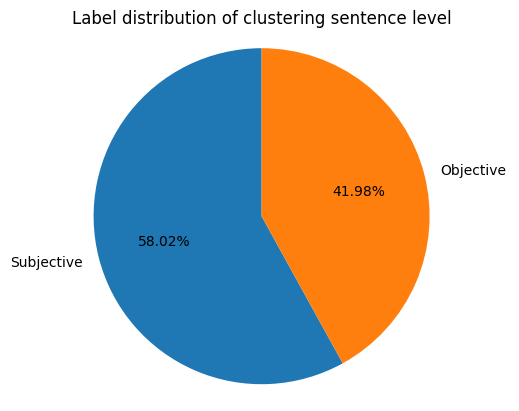

In [22]:
percentages = [subjective_percent_2, objective_percent_2]

plt.pie(percentages, labels=plot_labels, autopct='%0.2f%%', startangle=90)
plt.axis('equal')
plt.title('Label distribution of clustering sentence level')
plt.show()

# Objective vs. subjective: Semi-supervised

In [23]:
# Labeled-unlabeled split
labeled_data = df.iloc[:99]
unlabeled_data = df.iloc[99:]

# Feature extraction
X_labeled = vectoriser.fit_transform(labeled_data['preprocessed text'])
y_labeled = labeled_data['Gold Label']
X_unlabeled = vectoriser.transform(unlabeled_data['preprocessed text'])

# Train-test split
X_labeled_train, X_labeled_test, y_labeled_train, y_labeled_test = train_test_split(X_labeled, y_labeled, test_size=0.2)

# Logistic regression base model
model = LogisticRegression()
model.fit(X_labeled_train, y_labeled_train)

# Prediciting test labels
test_predictions = model.predict(X_labeled_test)

In [24]:
print(f"Classification report:\n {classification_report(y_labeled_test, test_predictions)}")

Classification report:
               precision    recall  f1-score   support

   objective       0.25      0.20      0.22         5
  subjective       0.75      0.80      0.77        15

    accuracy                           0.65        20
   macro avg       0.50      0.50      0.50        20
weighted avg       0.62      0.65      0.64        20



In [25]:
# Predicting labels
unlabeled_pred = model.predict(X_unlabeled)
unlabeled_probab = model.predict_proba(X_unlabeled)

# High confidence threshold
confidence = 0.9
confidence_index = np.where(np.max(unlabeled_probab, axis=1) > confidence)[0]
y_temp = unlabeled_pred[confidence_index]
X_temp = X_unlabeled[confidence_index]

# Retraining model on entire dataset
X_combined = vstack((X_labeled, X_temp))
y_combined = np.concatenate((y_labeled, y_temp))
model.fit(X_combined, y_combined)

# Predict labels for all the rows in the dataset
comment_vectors_semi = vectoriser.transform(df['preprocessed text'])
predictions = model.predict(comment_vectors_semi)

label_map = {'objective': 0, 'subjective': 1}
cluster_labels_semi = [label_map[label] for label in predictions]

# Add the new column to the DataFrame
df['Label Semi-Supervised'] = predictions

## Comparing semi-supervised to gold labels

In [26]:
print(f"Classification report for semi-supervised vs gold labels:\n {classification_report(df['Gold Label'].iloc[:99], df['Label Semi-Supervised'].iloc[:99])}")

Classification report for semi-supervised vs gold labels:
               precision    recall  f1-score   support

   objective       1.00      1.00      1.00        42
  subjective       1.00      1.00      1.00        57

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



## Comparing clustering case 1 to to semi-supervised

In [27]:
# Counting the same predictions between both cases
matches_case_1_semi = (df['Label Clustering: Case 1'] == df['Label Semi-Supervised']).sum()

# Calculating the percentage similarity
percentage_similarity_case_1_semi = round((matches_case_1_semi / len(df)) * 100, 2)

# Displaying the result
print(f"Percentage similarity between case 1 and semi-supervised: {percentage_similarity_case_1_semi}%")

Percentage similarity between case 1 and semi-supervised: 16.8%


## Comparing clustering case 2 to to semi-supervised

In [28]:
# Counting the same predictions between both cases
matches_case_2_semi = (df['Label Clustering: Case 2'] == df['Label Semi-Supervised']).sum()

# Calculating the percentage similarity
percentage_similarity_case_2_semi = round((matches_case_2_semi / len(df)) * 100, 2)

# Displaying the result
print(f"Percentage similarity between case 2 and semi-supervised: {percentage_similarity_case_2_semi}%")

Percentage similarity between case 2 and semi-supervised: 57.84%


## Distribution of labels in semi-supervised

In [29]:
count_semi = Counter(df['Label Semi-Supervised'])

subjective_semi = count_semi['subjective']
objective_semi = count_semi['objective']
total_semi = subjective_semi + objective_semi

subjective_percent_semi = round((subjective_semi / total_semi) * 100, 2)
objective_percent_semi = round((objective_semi / total_semi) * 100, 2)

In [30]:
print(f"Subjective labels semi-supervised: {subjective_percent_semi}%")
print(f"Objective labels semi-supervised: {objective_percent_semi}%")

Subjective labels semi-supervised: 98.37%
Objective labels semi-supervised: 1.63%


### Plotting distribution of semi-supervised

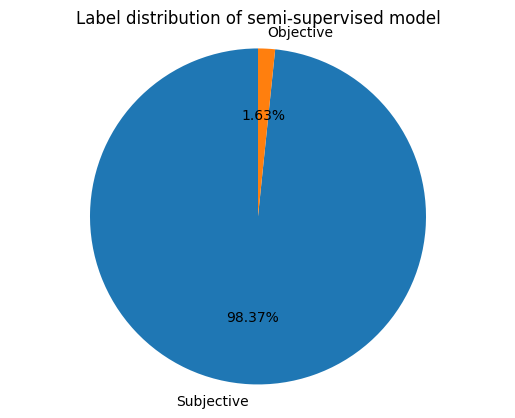

In [31]:
percentages = [subjective_percent_semi, objective_percent_semi]

plt.pie(percentages, labels=plot_labels, autopct='%0.2f%%', startangle=90)
plt.axis('equal')
plt.title('Label distribution of semi-supervised model')
plt.show()

# Objective vs. subjective: Thread analysis

## Modeling thread structure

In [32]:
threads_per_article = {}

for index, row in df.iterrows():
  # Defining features to be used for thread analysis
  comment_id = row['comment_id']
  parent_id = row['comment_parent_id']
  comment_type = cluster_labels_case_2[index]
  article_id = row['article_id']

  if article_id not in threads_per_article:
    threads_per_article[article_id] = {}

  if pd.isnull(parent_id) or parent_id not in threads_per_article[article_id]:
    threads_per_article[article_id][comment_id] = {'comment': preprocessed_text[index], 'replies': [], 'type': comment_type,
                                                   'subjective_count': 0, 'objective_count': 0}
  else:
    parent_thread = threads_per_article[article_id][parent_id]
    parent_thread['replies'].append({'comment': preprocessed_text[index], 'comment_id': comment_id, 'type': comment_type})

for article_id, threads in threads_per_article.items():
  for thread_id, thread in threads.items():
    thread['subjective_count'] = sum(reply['type'] == 1 for reply in thread['replies'])
    thread['objective_count'] = sum(reply['type'] == 0 for reply in thread['replies'])

## Function to assign the labels

In [33]:
def predict_comment_type(threads_per_article, comment_id, article_id):
    if article_id not in threads_per_article or comment_id not in threads_per_article[article_id]:
        return 'None'

    thread = threads_per_article[article_id][comment_id]
    subjective_count = thread['subjective_count']
    objective_count = thread['objective_count']

    if subjective_count > objective_count:
        return 'subjective'
    elif subjective_count < objective_count:
        return 'objective'
    else:
        return 'subjective' if thread['type'] == 1 else 'objective'


## Asigning labels based on replies

In [34]:
df['Label Thread'] = df.apply(lambda row: predict_comment_type(threads_per_article, row['comment_id'], row['article_id']), axis=1)

## Comparing thread analysis to gold labels

In [35]:
print(f"Classification report for semi-supervised vs gold labels:\n {classification_report(df['Gold Label'].iloc[:99], df['Label Thread'].iloc[:99])}")

Classification report for semi-supervised vs gold labels:
               precision    recall  f1-score   support

        None       0.00      0.00      0.00         0
   objective       0.41      0.29      0.34        42
  subjective       0.61      0.40      0.48        57

    accuracy                           0.35        99
   macro avg       0.34      0.23      0.27        99
weighted avg       0.52      0.35      0.42        99



## Comparing thread analysis to clustering case 1 labels

In [36]:
# Counting the same predictions between both cases
matches_thread_1 = (df['Label Clustering: Case 1'] == df['Label Thread']).sum()

# Calculating the percentage similarity
percentage_similarity_thread_1 = round((matches_thread_1 / len(df)) * 100, 2)

# Displaying the result
print(f"Percentage similarity between clustering case 1 and thread analysis: {percentage_similarity_thread_1}%")

Percentage similarity between clustering case 1 and thread analysis: 29.31%


## Comparing thread analysis to clustering case 2 labels

In [37]:
# Counting the same predictions between both cases
matches_thread_2 = (df['Label Clustering: Case 2'] == df['Label Thread']).sum()

# Calculating the percentage similarity
percentage_similarity_thread_2 = round((matches_thread_2 / len(df)) * 100, 2)

# Displaying the result
print(f"Percentage similarity between case 2 and thread analysis: {percentage_similarity_thread_2}%")

Percentage similarity between case 2 and thread analysis: 56.33%


## Comparing thread analysis to semi-supervised labels

In [38]:
# Counting the same predictions between both cases
matches_thread_semi = (df['Label Semi-Supervised'] == df['Label Thread']).sum()

# Calculating the percentage similarity
percentage_similarity_thread_semi = round((matches_thread_semi / len(df)) * 100, 2)

# Displaying the result
print(f"Percentage similarity between semi-supervised and thread analysis: {percentage_similarity_thread_semi}%")

Percentage similarity between semi-supervised and thread analysis: 35.73%


# Summary

In [39]:
article_opinion_counts = {}

for article_id, threads in threads_per_article.items():
  article_opinion_counts[article_id] = {'subjective': 0, 'objective': 0}
  for thread_id, thread in threads.items():
    article_opinion_counts[article_id]['subjective'] += thread['subjective_count']
    article_opinion_counts[article_id]['objective'] += thread['objective_count']
    article_opinion_counts[article_id]['subjective'] += 1 if thread['type'] == 1 else 0
    article_opinion_counts[article_id]['objective'] += 1 if thread['type'] == 0 else 0

summary = "Discussion Summary:\n\n"

for article_id, threads in threads_per_article.items():
  opinion_counts = article_opinion_counts[article_id]
  total_opinions = opinion_counts['subjective'] + opinion_counts['objective']
  perc_subjective = opinion_counts['subjective'] / total_opinions * 100
  perc_objective = opinion_counts['objective'] / total_opinions * 100

  summary += f"Article ID: {article_id}\n"
  summary += f"Percentage of Subjective Opinions: {perc_subjective:.2f}%\n"
  summary += f"Percentage of Objective Opinions: {perc_objective:.2f}%\n\n"

  summary += "Thread Analysis:\n"
  for thread_id, thread in threads.items():
    summary += f"\tParent Comment: {thread['comment']} (Type: {'Subjective' if thread['type'] == 1 else 'Objective'})\n"
    summary += f"\t\tSubjective Replies: {thread['subjective_count']}\n"
    summary += f"\t\tObjective Replies: {thread['objective_count']}\n"

    for reply in thread['replies']:
      summary += f"\t\tReply Comment: {reply['comment']} (Type: {'Subjective' if reply['type'] == 1 else 'Objective'})\n"

  summary += "\n"

In [40]:
with open("/content/drive/MyDrive/Colab Notebooks/BSc AI Thesis/summary.txt", "w") as file:
    file.write(summary)

In [41]:
df_2 = df_master.head(100)

In [42]:
df_2.to_csv('/content/drive/MyDrive/Colab Notebooks/BSc AI Thesis/defense.csv', index=False)